## I. Loading and preprocessing data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read the data
matches = pd.read_csv('data/training_data.csv')
# rename the columns
matches.columns = ['Month', 'White_Player', 'Black_Player', 'Score']


In [3]:
matches

,Month,White_Player,Black_Player,Score
0,1,73,1246,0.5
1,1,73,5097,0.5
2,1,73,5104,0.5
3,1,73,7321,1.0
4,1,73,7375,0.5
...,...,...,...,...
65048,100,8617,1536,0.5
65049,100,8621,102,0.0
65050,100,8621,5463,1.0
65051,100,8621,5814,0.5


In [4]:
# check if players did play against each other more than once

if matches.duplicated(['White_Player', 'Black_Player']).any():
    print('At least one pair Players did play against each other more than once')
else:
    # swap the players and add them to the dataframe
    matches_swap = matches.copy()
    matches_swap['White_Player'] = matches['Black_Player']
    matches_swap['Black_Player'] = matches['White_Player']
    # append the swapped matches to the original dataframe
    ckeck_dataframes = matches.append(matches_swap)
    # check if players did play against each other more than once
    if ckeck_dataframes.duplicated(['White_Player', 'Black_Player']).any():
        print('At least one pair Players did play against each other more than once')
    else:
        print('No pair Players did play against each other more than once')

At least one pair Players did play against each other more than once


Since players can play each other more than once, our graph is a directed multigraph. We will use the `networkx` library to represent the graph and perform graph operations.

In [5]:
# build the network graph (edges from white to black, score and month as edge attributes)
import networkx as nx
import matplotlib.pyplot as plt

# create a directed multigraph
G = nx.from_pandas_edgelist(matches, 'White_Player', 'Black_Player', ['Score', 'Month'], create_using=nx.MultiDiGraph())

## II. Exploratory analysis

### 1. Basic properties of the graph

In [6]:
# Compute the basic statistics for the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average in-degree:", round(sum(dict(G.in_degree()).values()) / G.number_of_nodes(), 4))
print("Average out-degree:", round(sum(dict(G.out_degree()).values()) / G.number_of_nodes(), 4))

Number of nodes: 7301
Number of edges: 65053
Average in-degree: 8.9101
Average out-degree: 8.9101


Based on these values, we can see that the graph has 7301 nodes (players) and 65053 edges (matches), with an average in-degree and out-degree of 8.9101. Since each match has one white and one black player, the average in-degree and out-degree should be the same.

### 2. Graph properties anlaysis

#### 2.1. Degree distribution

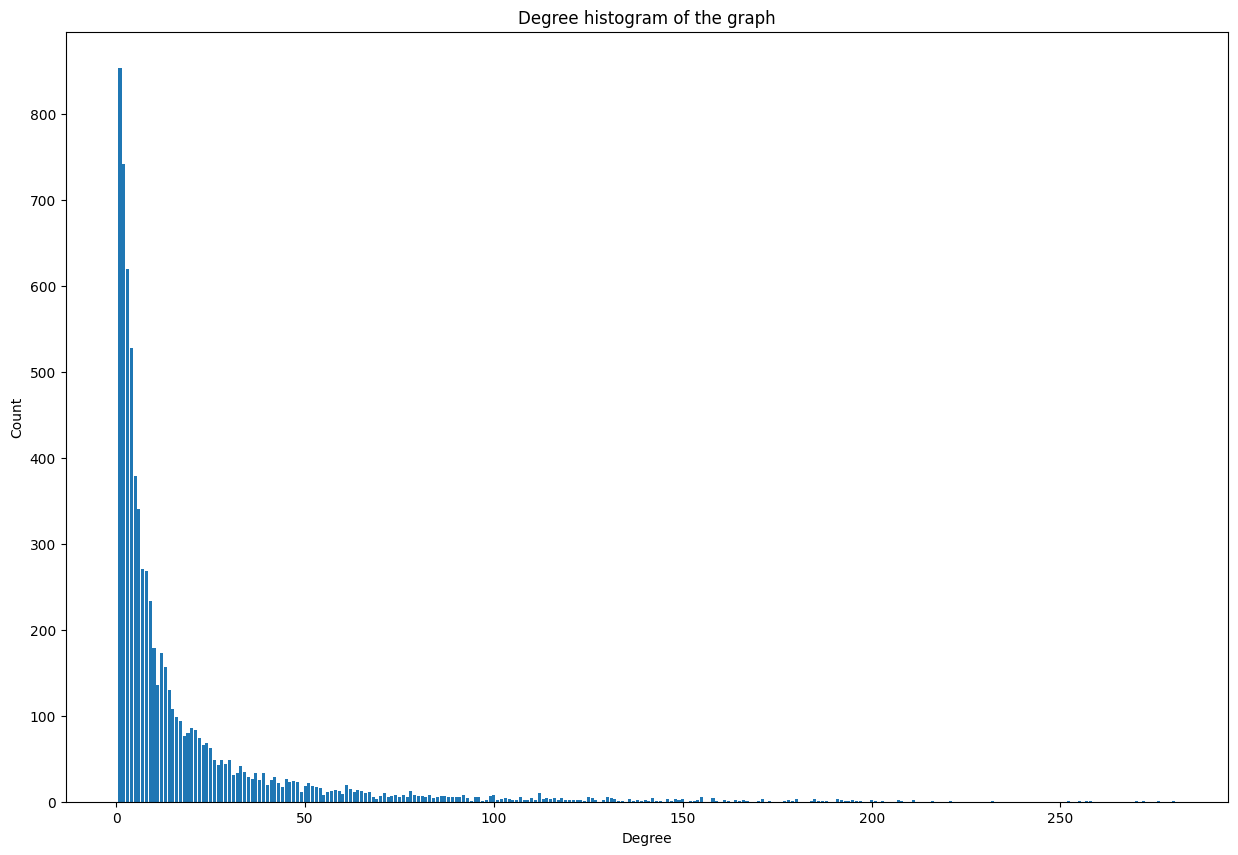

In [7]:
from collections import Counter

# Compute the degree distribution of the graph
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = Counter(degree_sequence)
degree, count = zip(*degree_count.items())

# Plot the degree distribution of the graph
plt.figure(figsize=(15, 10))
plt.bar(degree, count, width=0.8)
plt.title("Degree histogram of the graph")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()



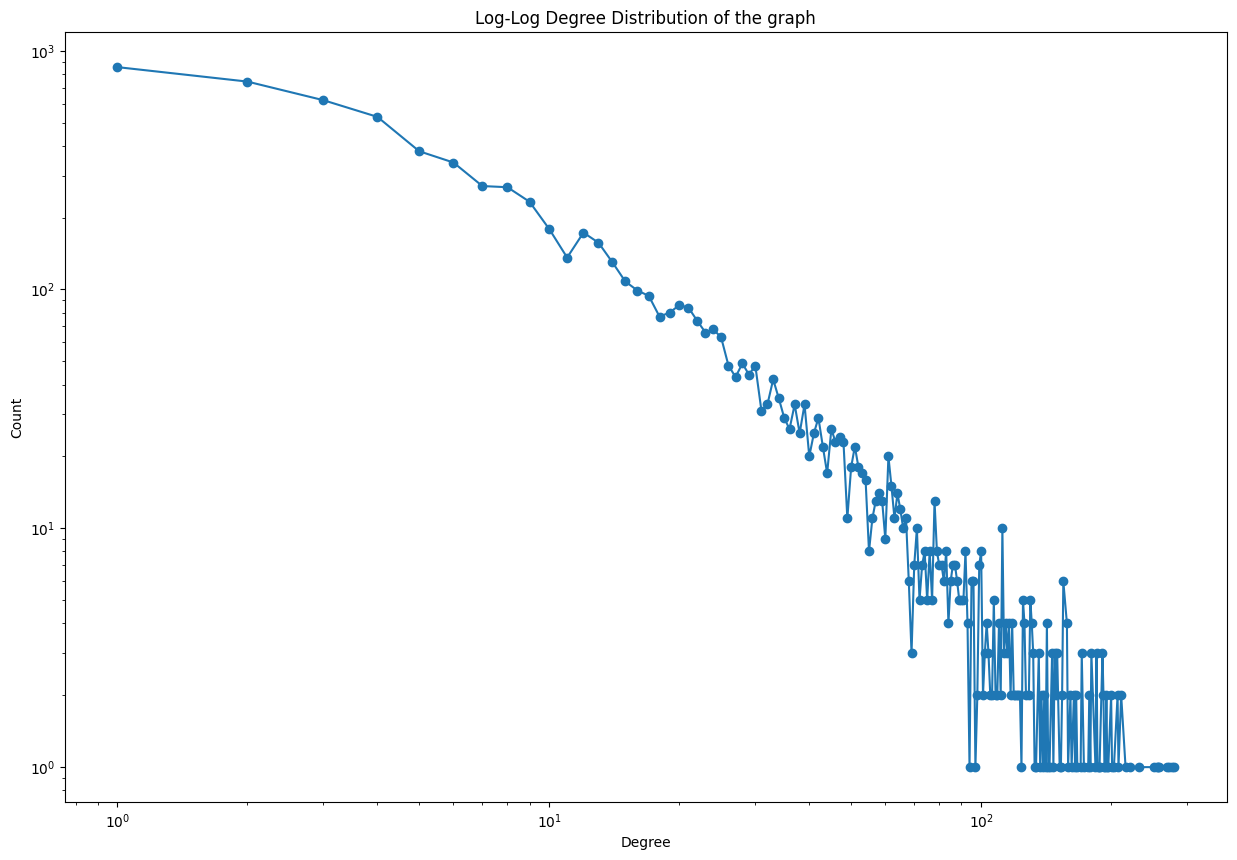

In [8]:
# scatter log-log plot of the degree distribution
plt.figure(figsize=(15, 10))
plt.loglog(degree, count, marker='o')
plt.title("Log-Log Degree Distribution of the graph")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

We can clearly see that the distribution is a power law, as the log-log plot shows a linear relationship between the log of the degree and the log of the frequency. This indicates that the heavy-tailed distribution of the degree sequence is consistent with a power law distribution. This information is crucial in selecting appropriate models for the learning section, as well as in designing an appropriate sampling strategy for the training, validation, and test sets.

One viable option for sampling is to use a stratified sampling strategy that takes into account the degree distribution. This strategy would ensure that the selected sets have similar distributions, which would ensure proper evaluation of our model. However, it is important to acknowledge that this approach may lead to some players being overrepresented in the training set, while others are underrepresented, which may bias the predictions. Thus, it is crucial to carefully evaluate the model's performance on both overrepresented and underrepresented players to ensure that it performs well on all players. Additionally, it may be necessary to consider other strategies such as oversampling or undersampling to address potential issues with bias in the dataset.

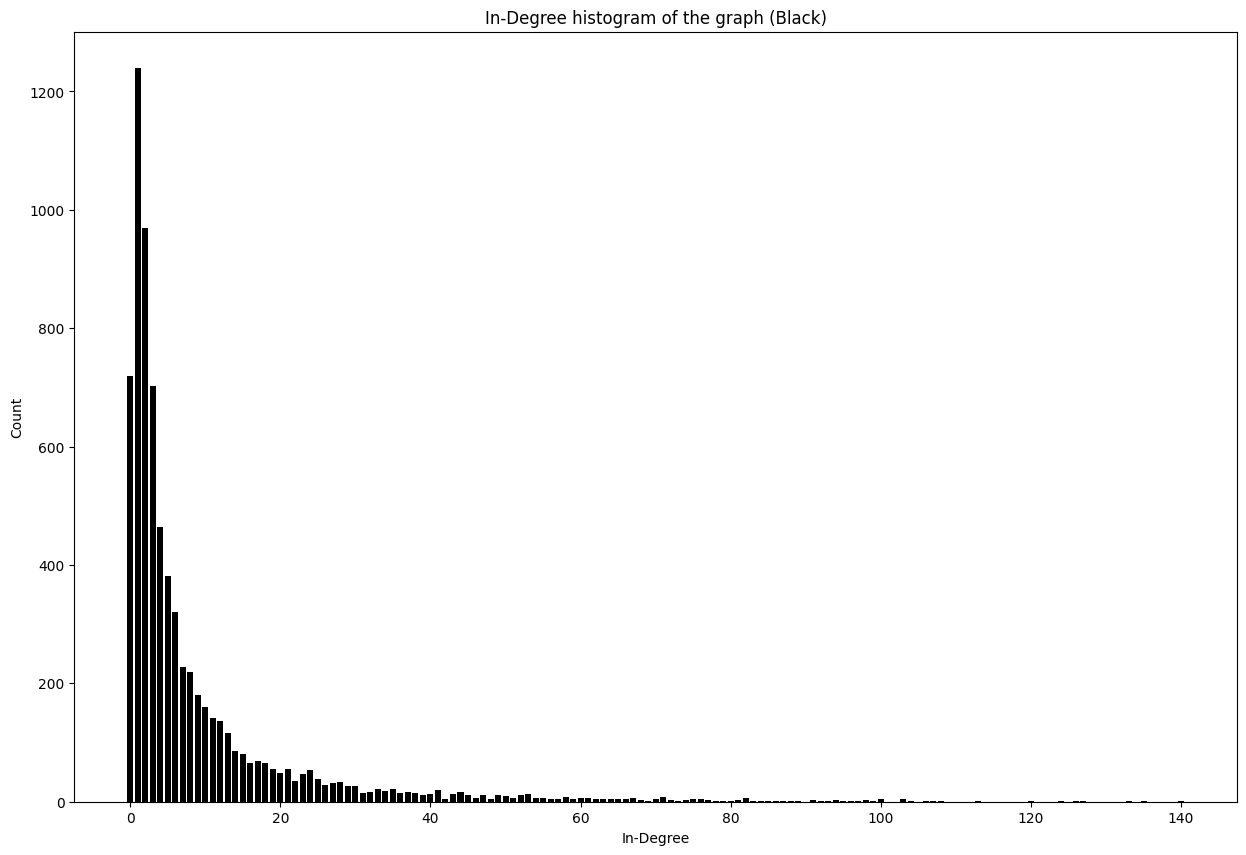

In [9]:
black_degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
black_degree_count = Counter(black_degree_sequence)
black_degree, black_count = zip(*black_degree_count.items())

# Plot the degree distribution of the graph
plt.figure(figsize=(15, 10))
plt.bar(black_degree, black_count, width=0.8, color='black')
plt.title("In-Degree histogram of the graph (Black)")
plt.xlabel("In-Degree")
plt.ylabel("Count")
plt.show()

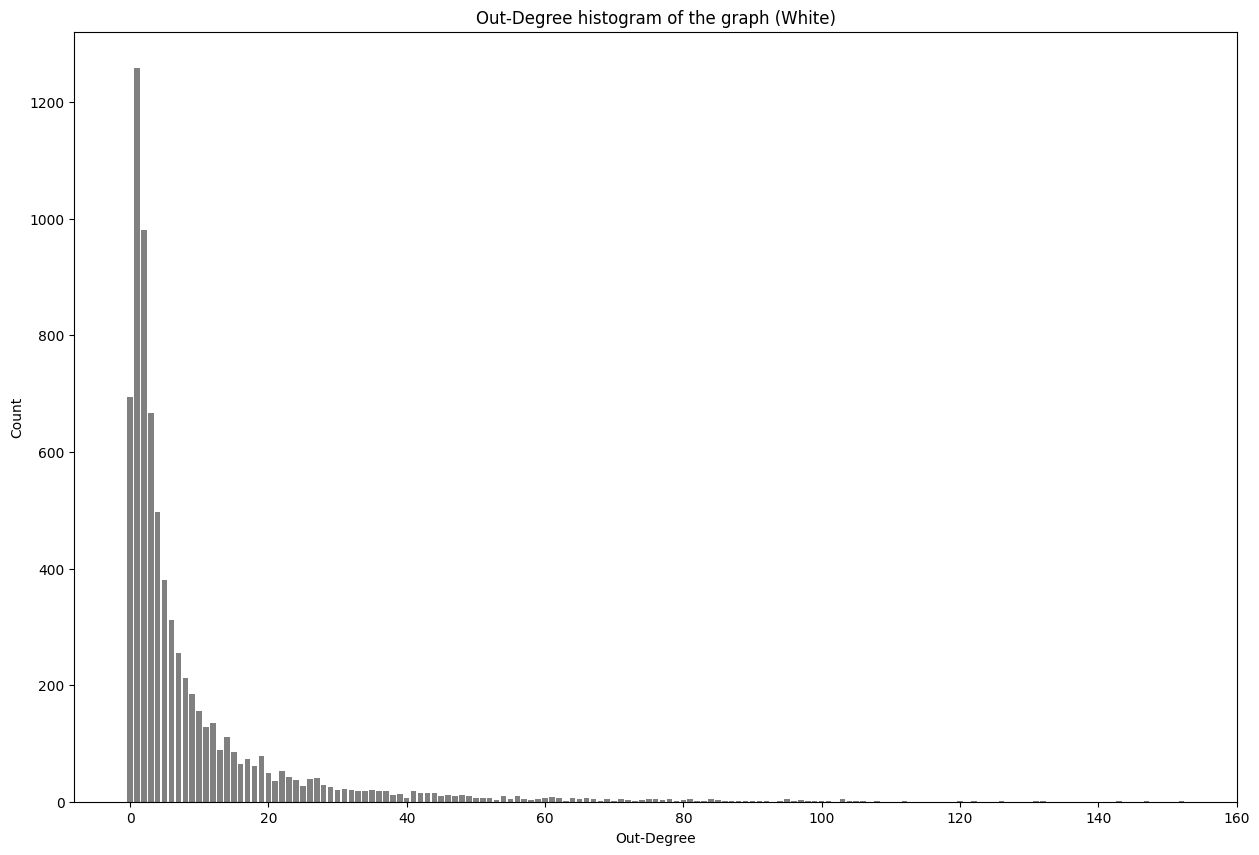

In [10]:
white_degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
white_degree_count = Counter(white_degree_sequence)
white_degree, white_count = zip(*white_degree_count.items())

# Plot the degree distribution of the graph
plt.figure(figsize=(15, 10))
plt.bar(white_degree, white_count, width=0.8, color='Grey')
plt.title("Out-Degree histogram of the graph (White)")
plt.xlabel("Out-Degree")
plt.ylabel("Count")
plt.show()

The in-degree and out-degree distributions of the network exhibit a high degree of similarity and conform to the same power law distribution. Nonetheless, it is worth highlighting that a proportion of approximately 10% of players appear to have either never played as black, or never played as white, as indicated by an out-degree or in-degree of zero, respectively. It is likely that many of these players are  individuals who have participated in a single match. In the upcoming analysis, we will concentrate on the number of matches that are played exclusively by players who have participated as either black or white.

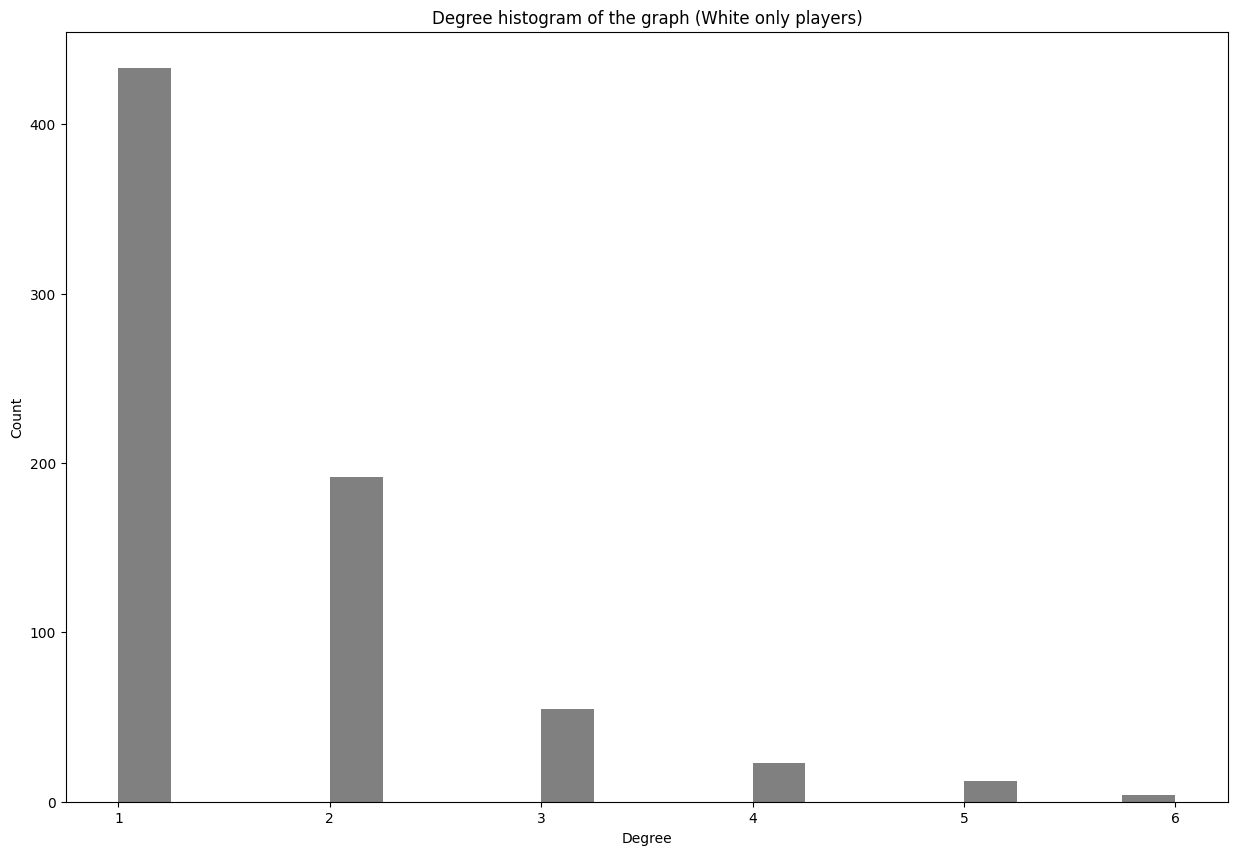

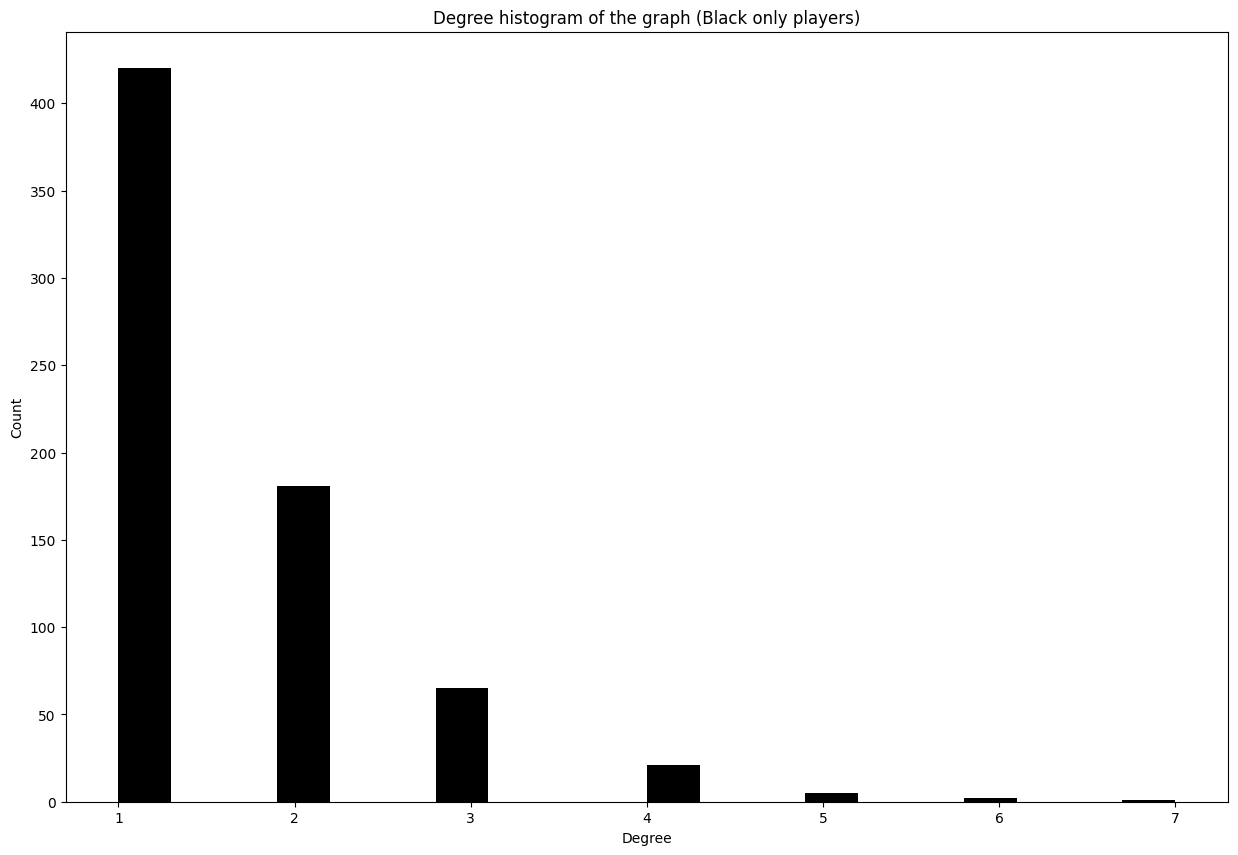

In [11]:
white_only_players = [n for n, d in G.in_degree() if d == 0]
black_only_players = [n for n, d in G.out_degree() if d == 0]

white_only_players_degree = [G.degree(n) for n in white_only_players]
black_only_players_degree = [G.degree(n) for n in black_only_players]

# Plot the degree distribution of the graph
plt.figure(figsize=(15, 10))
plt.hist(white_only_players_degree, bins=20, color='Grey')
plt.title("Degree histogram of the graph (White only players)")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

# Plot the degree distribution of the graph
plt.figure(figsize=(15, 10))
plt.hist(black_only_players_degree, bins=20, color='black')
plt.title("Degree histogram of the graph (Black only players)")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()


#### 2.2. Connected components

In [12]:
# Find out wether the graph is strongly connected
if nx.is_strongly_connected(G):
    print("Graph is strongly connected")
else:
    print("Graph is not strongly connected")

Graph is not strongly connected


In [13]:
# to undirected graph
G_undirected = G.to_undirected()

# Calculate the connected components of the graph
components = list(nx.connected_components(G_undirected))

# Print the number of connected components and the size of the largest component
print(f"Number of connected components: {len(components)}")
print(f"Size of largest connected component: {len(max(components, key=len))}")


Number of connected components: 77
Size of largest connected component: 7115


The size of the largest connected component, 7115, indicates that the majority of players in the community are connected to each other through a chain of edges, and that there is a large community of players who did play one another. However, it is noteworthy that the graph contains 77 connected components, which implies that certain subsets of nodes lack edges connecting them to each other. This suggests that the players in the chess community do not participate in matches with each other uniformly, and that apart from the largest connected component, there are several smaller communities of players who play each other more frequently than they play players outside of their community.

In [14]:
# Calculate the sparsity of the graph
density = nx.density(G)

# Print the sparsity
print(f"Graph sparsity: {density}")

Graph sparsity: 0.0012205683965229009


The sparsity of our chess match network is very low, indicating that the graph is not dense and that there are few edges compared to the maximum possible number of edges. This once again indicates that the players in the chess community do not play against each other uniformly which is consistent with the presence of 77 connected components.

### 3. Node properties

In [15]:
# Import the necessary packages
import community

# Compute the modularity of the nodes
partition = community.best_partition(G_undirected)
modularity = community.modularity(partition, G_undirected)

# Print the modularity
print(f"Modularity of the nodes: {modularity}")
# compute the clustering coefficient 
no_multigraph = nx.Graph(G_undirected)
clustering_coefficient = nx.average_clustering(no_multigraph)
print(f"Clustering coefficient: {clustering_coefficient}")

Modularity of the nodes: 0.47184970262798687
Clustering coefficient: 0.17669736820407259


The modularity of our chess match network is relatively high, but the clustering coeficient is well below average. This  suggests that there are specific groups or communities of players within the network that tend to play against each other more frequently than against other groups, but these groups may not be tightly connected internally in accordance with the low density of the graph.

This means that there are distinct groups of players who tend to play against each other more frequently, but the matches between them are not  highly correlated. In other words, the outcome of a match between players in one group may not strongly predict the outcome of a match between players in another group.

Therefore, when developing a predictive model for the chess match outcomes based on the historical performance of the players, it may be important to take into account the community structure of the network

### 4. Edge attributes

In [16]:
# Compute the the average of scores and matches per month (bar chart)
score_per_month = matches.groupby('Month')['Score'].mean()
matches_per_month = matches['Month'].value_counts().sort_index()
scores_value_counts = matches['Score'].value_counts().sort_index()

# print the scores value counts
print(scores_value_counts)

0.0    15224
0.5    28666
1.0    21163
Name: Score, dtype: int64


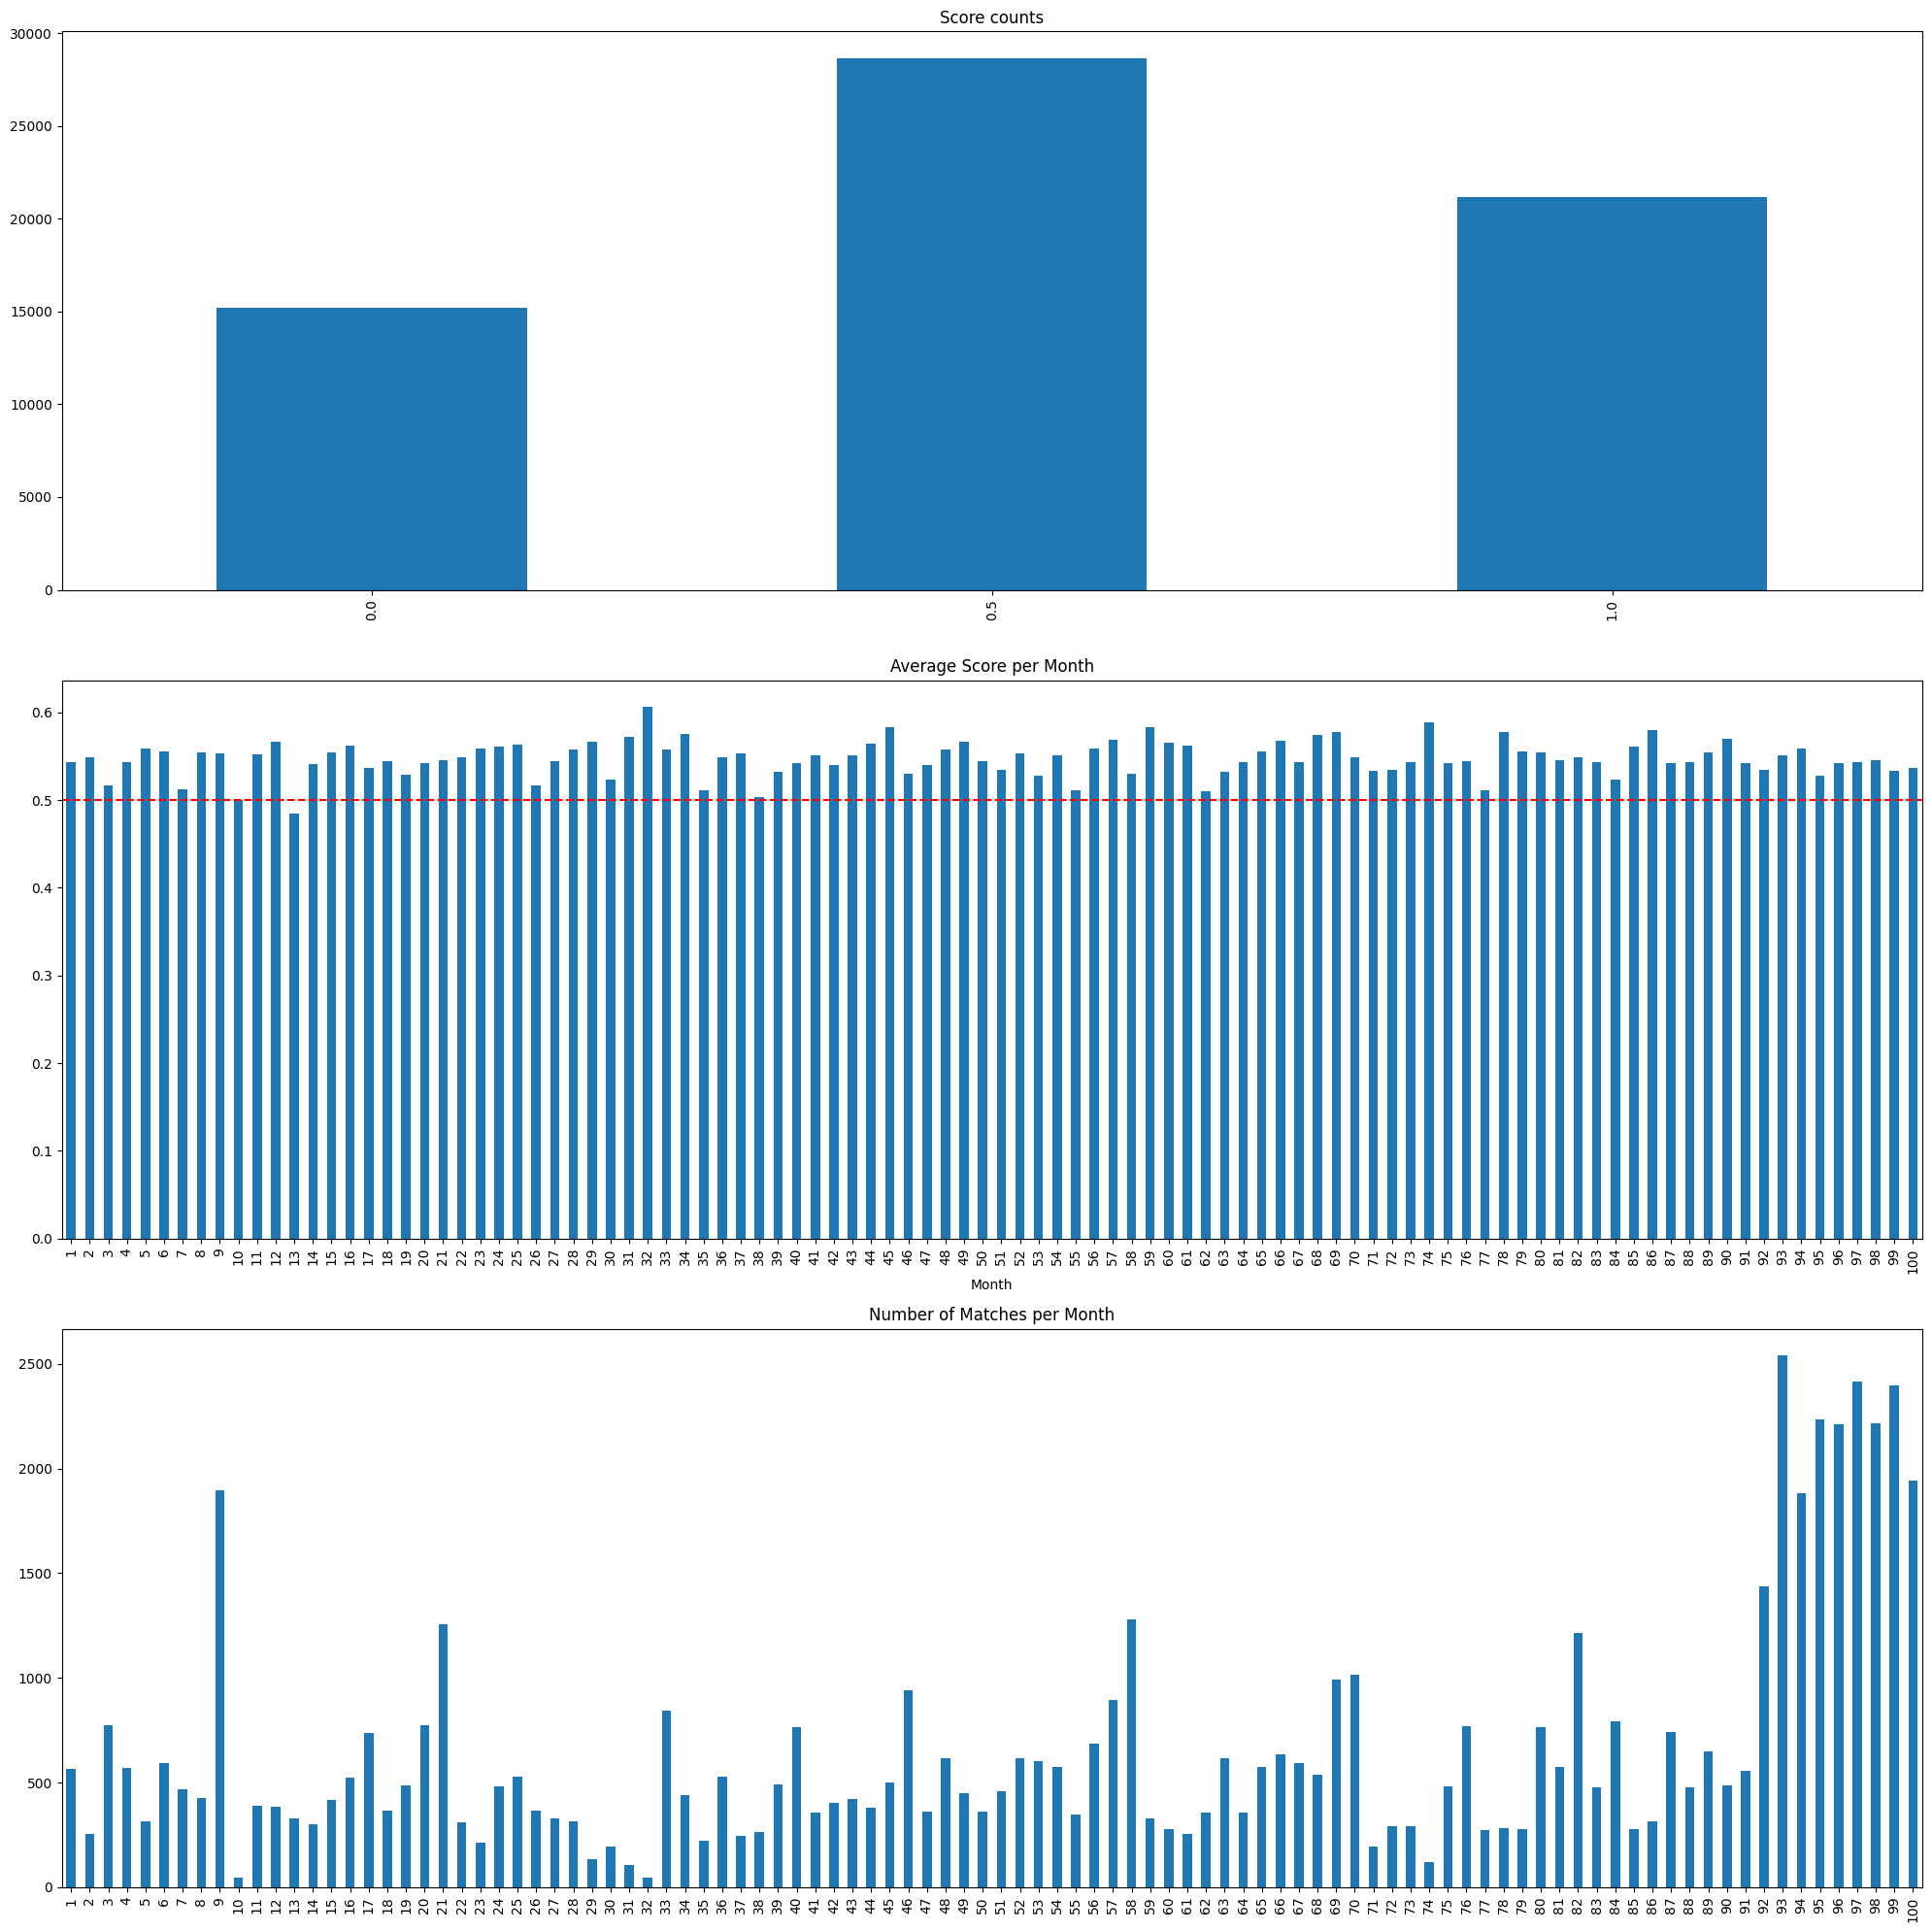

In [17]:
# Plot the distribution of scores and matches per month
fig, ax = plt.subplots(3, figsize=(20, 20))
scores_value_counts.plot(kind='bar', ax=ax[0])
score_per_month.plot(kind='bar', ax=ax[1])
ax[0].set_title('Score counts')
ax[1].set_title('Average Score per Month')
matches_per_month.plot(kind='bar', ax=ax[2])
# include horizontal line at y = 0.5
ax[1].axhline(0.5, color='red', linestyle='--')
ax[2].set_title('Number of Matches per Month')
plt.tight_layout()
plt.show()


In [18]:
# Import necessary modules
import numpy as np
import scipy.stats as stats

# Compute the matches per month distribution
matches_per_month = matches['Month'].value_counts()

# Define the candidate distributions
distributions = [stats.norm, stats.expon, stats.weibull_min, stats.lognorm]

# Fit each distribution to the data and compute the AIC score
best_distribution = None
best_params = None
best_aic = np.inf
for distribution in distributions:
    # Fit the distribution to the data
    params = distribution.fit(matches_per_month)
    # Compute the log-likelihood of the data under the distribution
    log_likelihood = distribution.logpdf(matches_per_month, *params).sum()
    # Compute the AIC score for the distribution
    aic = 2 * len(params) - 2 * log_likelihood
    # Update the best fit distribution if the AIC score is lower
    if aic < best_aic:
        best_distribution = distribution
        best_params = params
        best_aic = aic

# Print the best fit distribution and its parameters
print('Best fit distribution:', best_distribution.name)
print('Parameters:', best_params)
print('AIC score:', best_aic)



Best fit distribution: expon
Parameters: (46.0, 604.53)
AIC score: 1484.8902593229986


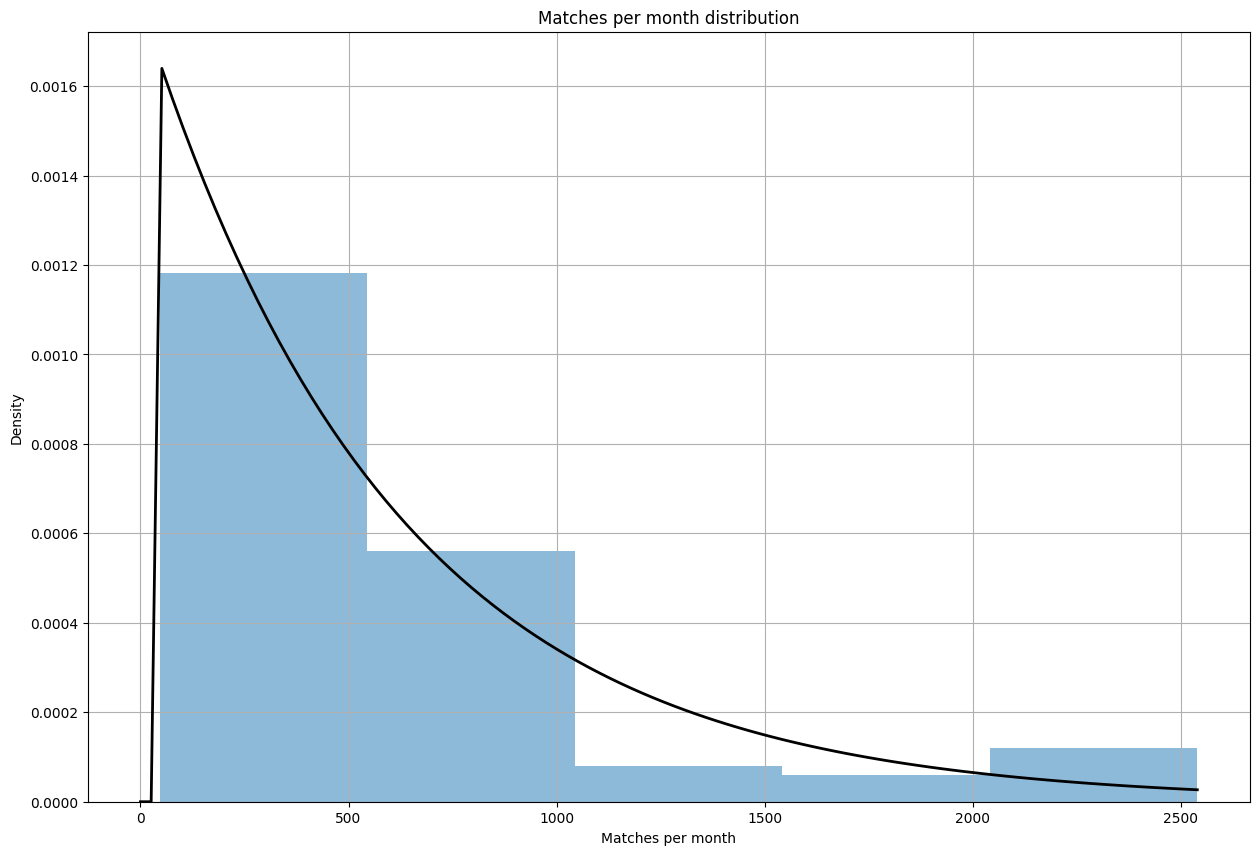

In [19]:
# Import necessary modules
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the exponential distribution with the best fit parameters
rv = stats.expon(loc=46, scale=604.53)

# Generate a histogram of the matches per month data
plt.figure(figsize=(15, 10))
matches_per_month.hist(bins=5, alpha=0.5, density=True)

# Plot the PDF of the exponential distribution over the histogram
x = np.linspace(0, matches_per_month.max(), 100)
plt.plot(x, rv.pdf(x), 'k-', lw=2)

# Set the axis labels and title
plt.xlabel('Matches per month')
plt.ylabel('Density')
plt.title('Matches per month distribution')

# Show the plot
plt.show()


The analysis of the edge attributes of the chess matches dataset reveals interesting patterns in both the average score and number of matches per month. Firstly, the average score per month appears to follow a uniform pattern, which is slightly skewed towards the white players. This is consistent with the fact that the white player has an advantage in chess due to moving first.

On the other hand, the number of matches per month appears to follow an exponential distribution, with a large number of months having a small number of matches, and a small number of months having a large number of matches. 

Regarding the labels, the value counts show that out of the 65,053 matches, black won 15,224, white won 21,163, and 28,666 ended in a draw. This information is useful in understanding the balance of outcomes in the dataset and could inform the design of our prediction model. For example, since there are more draws than wins for either color, it may be more difficult to accurately predict the outcome of a match compared to a binary classification task where the goal is to predict a winner or loser. We would also have to consider this when choosing a sampling strategy or when evaluating the performance of our model.

## III. Network visulization

## IV. New features

Player win/draw/loss ratios:

In [20]:
# For the white player
white_win_ratio = matches.groupby('White_Player')['Score'].mean()

# For the black player
black_win_ratio = 1 - matches.groupby('Black_Player')['Score'].mean()

# Combine these two dataframes to get the win ratio for each player
win_ratio = pd.concat([white_win_ratio, black_win_ratio]).groupby(level=0).mean()


Head-to-head performance

In [21]:
# Create a DataFrame of player pairs and their scores
player_pairs = matches[['White_Player', 'Black_Player', 'Score']]

# Compute the average score for each pair of players
head_to_head_performance = player_pairs.groupby(['White_Player', 'Black_Player']).mean()


In [49]:
head_to_head_performance_reset = head_to_head_performance.reset_index()
head_to_head_performance_reset['player_pair'] = list(zip(head_to_head_performance['White_Player'], head_to_head_performance['Black_Player']))
head_to_head_dict = dict(zip(head_to_head_performance_reset['player_pair'], head_to_head_performance_reset['Score']))


Cumulative monthly performance

In [23]:
# Convert Month column to datetime format
matches['Month'] = pd.to_datetime(matches['Month'])

# Sort the dataframe by player and date
matches_sorted = matches.sort_values(['White_Player', 'Month'])

# Group by player and calculate cumulative mean score for each month
matches_sorted['Cumulative_Monthly_Performance'] = matches_sorted.groupby('White_Player')['Score'].expanding().mean().reset_index(level=0, drop=True)
comulative_monthly_performance = matches_sorted['Cumulative_Monthly_Performance'] 
# Reset index to original dataframe's index
matches_sorted.reset_index(drop=True, inplace=True)
matches = matches_sorted


Player color preference

In [24]:
# For each player, compute their average score when playing as white and as black
white_performance = matches.groupby('White_Player')['Score'].mean()
black_performance = 1 - matches.groupby('Black_Player')['Score'].mean()

# Compute the difference in performance between playing as white and as black
color_preference = white_performance - black_performance
# replace nan values with 0
color_preference.fillna(0, inplace=True)

In [52]:
# Add these features to node/edge attributes

# Add win_ratio as a node attribute
nx.set_node_attributes(G, win_ratio.to_dict(), 'win_ratio')

# Add color_preference as a node attribute
nx.set_node_attributes(G, color_preference.to_dict(), 'color_preference')

# Add cumulative monthly performance as a node attribute
nx.set_node_attributes(G, comulative_monthly_performance.to_dict(), 'comulative_monthly_performance')

# add head to head performance as an edge attribute
# Iterate through all edges in the graph
for u, v, key in G.edges(keys=True):

    # Check if the edge is in the head-to_head_dict dictionary
    if (u, v) in head_to_head_dict:

        # If the edge is in the dictionary, add the 'score' attribute to the edge
        G[u][v][key]['score'] = head_to_head_dict[(u, v)]



In [ ]:
from torch_geometric.utils import from_networkx

# convert graph into PyTorch Geometric data object
data = from_networkx(G)

## V. Model

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

In [43]:
### LOAD DATASETS

BATCH_SIZE = 2 

# Train Dataset
train_dataset = pd.read_csv('data/training_data.csv')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = pd.read_csv('data/cross_validation_dataset.csv')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = pd.read_csv('data/test_data.csv')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Convert the DataFrame to a tensor
feature_columns = train_dataset.columns[:-1]  # adjust according to your dataset
label_column = train_dataset.columns[-1]  # adjust according to your dataset

train_features = torch.tensor(train_dataset[feature_columns].values, dtype=torch.float)
train_labels = torch.tensor(train_dataset[label_column].values, dtype=torch.long)

# Now, you can calculate the number of features and classes
n_features = train_features.shape[1]
n_classes = len(torch.unique(train_labels))


print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset.iloc[0])
print("Edge_index :")
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Number of samples in the train dataset:  65053
Number of samples in the val dataset:  7809
Number of samples in the test dataset:  7809
Output of one sample from the train dataset:  Month #              1.0
White Player #      73.0
Black Player #    1246.0
Score                0.5
Name: 0, dtype: float64
Edge_index :
Number of features per node:  3
Number of classes per node:  2


In [44]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

In [45]:
def evaluate(model, loss_fcn, device, dataloader):

    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

In [48]:
class GATModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.elu = nn.ELU()
        self.gatconv1 = graphnn.GATConv(input_size, hidden_size, heads=4, concat=True)
        self.gatconv2 = graphnn.GATConv(hidden_size * 4, hidden_size, heads=4, concat=True)
        self.gatconv3 = graphnn.GATConv(hidden_size * 4, output_size, heads=6, concat=False)

    def forward(self, x, edge_index):
        x = self.gatconv1(x, edge_index)
        x = self.elu(x)
        x = self.gatconv2(x, edge_index)
        x = self.elu(x)
        x = self.gatconv3(x, edge_index)

        return x


In [ ]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

## Student model
model = GATModel(input_size=50, hidden_size=128, output_size=121).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

